In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from opt import generate_exclusion_list
from theano import tensor as T

sns.set_context('paper', font_scale=1.5)

/anaconda2/envs/compgen/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
proc_data = pd.read_pickle('data/exp1_data.pkl')

# exclude! ...
excluded = generate_exclusion_list(proc_data, training_contexts=5, goal_chance=1/3.)
for e in excluded:
    proc_data = proc_data[proc_data.subj != e]
uids = list(set(proc_data.subj))
print len(uids)

100%|██████████| 149/149 [01:30<00:00,  1.94it/s]


115


# Analyses

In [3]:
proc_data['Accuracy'] = proc_data['Reward'] / 10.0
proc_data['Training'] = proc_data.loc[:, 'Context'] < 6

Below, we plot the training data as a check that subjects learned the task

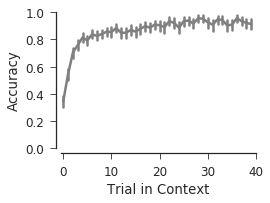

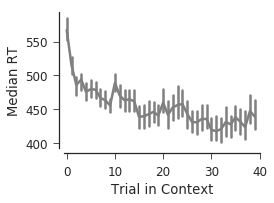

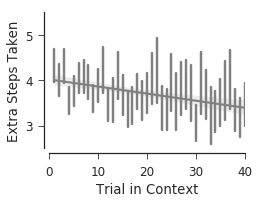

In [4]:
import scipy.stats
color = 'grey'
figsize = (3.5, 2.5)

with sns.axes_style('ticks'):
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='Accuracy', 
                  data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                  ax=ax, markers=' ', color=color)
    lb, ub = ax.get_xlim()
    lb, ub = int(lb), int(ub)
    step = 10
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([0, 1])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='rt', data=proc_data[proc_data['Training']], 
                  estimator=np.median, ax=ax,  markers=' ', color=color)
    ax.set_ylabel('Median RT')
    ax.set_xlabel('Trial in Context')
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    sns.despine(offset=5)
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.regplot(x='Times Seen Context', y='Normalized Steps Taken',
                x_estimator=np.mean,
                data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                truncate=True,
                ax=ax, marker= ' ', color=color)
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([2.5, 5.5])
    ax.set_xlim([lb, ub+1])
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylabel('Extra Steps Taken')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)

In [5]:
# create meaningful regressors
# really on only want to look at training
X0 = proc_data[proc_data['Training'] & proc_data['In Goal']].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii
n_subj = int(max(X0.sub_id) + 1)

y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_train_acc:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps',  mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_train_acc = pm.sample()
    
pm.stats.summary(trace_train_acc, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 1000/1000 [04:16<00:00,  3.90it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.108452,0.00485,0.000195,0.099029,0.117639,465.0,1.007616
beta_reps,1.104702,0.05768,0.001627,0.988464,1.211411,1000.0,1.003475


In [6]:
y = np.array(1. / X0['rt'].values)
y = (y - y.mean()) / y.std()

with pm.Model() as glm_rt:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps',  mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat =  b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    # inference
    trace_rt = pm.sample()
    
pm.stats.summary(trace_rt, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 1000/1000 [02:18<00:00,  7.21it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.007642,0.000667,0.000023,0.006296,0.008799,863.0,0.999429
beta_reps,0.054472,0.016590,0.000541,0.023437,0.085945,942.0,0.999292


In [7]:
y = np.array(X0['Normalized Steps Taken'].values)

with pm.Model() as glm_steps:

    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=5.)  # have to use a more restrictive prior for the Poisson regression
    b_cr = pm.Normal('beta_reps',  mu=0., sd=5.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)

    # define linear model and exp link function
    theta = b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
            
    ## Define Poisson likelihood
    y_hat = pm.Poisson('y', mu=np.exp(theta), observed=y)
    
    
    # inference
    trace_steps = pm.sample()
    
pm.stats.summary(trace_steps, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 1000/1000 [01:11<00:00, 13.96it/s]
The acceptance probability does not match the target. It is 0.8794269346661997, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,-0.003517,0.000380,0.000014,-0.004222,-0.002754,641.0,0.999171
beta_reps,-0.406451,0.010043,0.000290,-0.425274,-0.385813,1000.0,0.999313


Here, we plot the differences scores for the test conditions across time. Thes are the a priori comparisons identified by the generative models

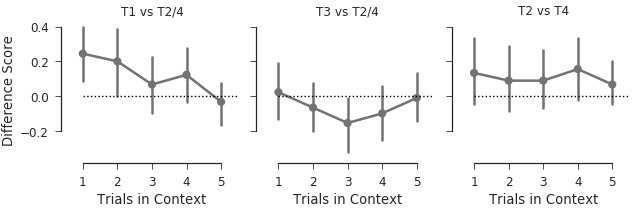

In [8]:
# plot the difference scores across time
df0 = df = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
                     (proc_data['Times Seen Context'] < 6)].copy()

score = list()

for uid in uids:
    subj_df = df0.loc[df0.subj == uid, :]

    if subj_df['Trial Number'].max() == df0['Trial Number'].max():

        grouped = subj_df.groupby(['Context', 'Times Seen Context']).mean()

        diff_1 = grouped.loc[6, 'Accuracy'] - 0.5 * (grouped.loc[7, 'Accuracy'] + \
                                                     grouped.loc[9, 'Accuracy'])
        diff_2 = grouped.loc[8, 'Accuracy'] - 0.5 * (grouped.loc[7, 'Accuracy'] + \
                                                     grouped.loc[9, 'Accuracy'])
        diff_3 = grouped.loc[7, 'Accuracy'] -  grouped.loc[9, 'Accuracy']
        diff_4 = grouped.loc[6, 'Accuracy'] -  grouped.loc[9, 'Accuracy']
        diff_5 = grouped.loc[8, 'Accuracy'] -  grouped.loc[7, 'Accuracy']


        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1 vs T2/4'] * n,
                    'Difference Score': diff_1,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T3 vs T2/4'] * n,
                    'Difference Score': diff_2,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T2 vs T4'] * n,
                    'Difference Score': diff_3,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1 vs T2'] * n,
                    'Difference Score': diff_4,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T3 vs T4'] * n,
                    'Difference Score': diff_5,
                    'uniqueid': [uid] * n,
            }))

score = pd.concat(score)      
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T1 vs T2/4'],  
                  ax=axes[0], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T3 vs T2/4'], 
                  ax=axes[1], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T2 vs T4'],  
                  ax=axes[2], color=[0.45, 0.45, 0.45])
    

    axes[0].set_xticklabels(range(1, 7))
    axes[0].set_ylabel('Difference Score')
    axes[1].set_ylabel('')
    axes[2].set_ylabel('')
    
    axes[0].set_title('T1 vs T2/4', fontdict={'size': 12})
    axes[1].set_title('T3 vs T2/4', fontdict={'size': 12})
    axes[2].set_title('T2 vs T4', fontdict={'size': 12})
    
    for ax in axes:
        ax.plot([0, 6], [0, 0], 'k:')
    
    plt.subplots_adjust(wspace=0.3)
    sns.despine(offset=5, trim=True)
    plt.tight_layout()


In [9]:
# run the bayesian GLM on the raw data

# create meaningful regressors
# really on only want to look at training
X0 = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
               (proc_data['Times Seen Context'] <= 5)].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)


y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_1 = np.array(X0.Context.values == 6, dtype=int) - \
     ((X0.Context.values == 7) | (X0.Context.values == 9))
    
x_2 = np.array(X0.Context.values == 8, dtype=int) - \
     ((X0.Context.values == 7) | (X0.Context.values == 9))
    
x_3 = np.array(X0.Context.values == 7, dtype=int) - \
     (X0.Context.values == 9)
    
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_1 = pm.Normal('beta_ctxT1vs24', mu=0., sd=100)
    b_2 = pm.Normal('beta_ctxT3vs24',  mu=0., sd=100)
    b_3 = pm.Normal('beta_ctxT2vs4',   mu=0., sd=100)
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_1 * x_1 + b_2 * x_2 + b_3 * x_3 + \
                      b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times, beta_ctxT2vs4, beta_ctxT3vs24, beta_ctxT1vs24]
100%|██████████| 1000/1000 [01:05<00:00, 15.37it/s]


In [10]:
summary = pm.stats.summary(trace, varnames=['beta_ctxT1vs24', 'beta_ctxT3vs24','beta_ctxT2vs4',
                                  'beta_times', 'beta_reps'])
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_ctxT1vs24,0.317682,0.079916,0.001885,0.158593,0.468682,1000.0,0.999049
beta_ctxT3vs24,-0.246322,0.073159,0.002000,-0.385602,-0.101305,1000.0,0.999194
beta_ctxT2vs4,0.074929,0.070590,0.001685,-0.060690,0.216399,1000.0,0.999160
beta_times,0.433501,0.036710,0.001815,0.364969,0.504346,423.0,0.999002
beta_reps,0.752664,0.134004,0.003076,0.499703,1.018576,1000.0,0.999505


In [11]:
print np.mean(trace['beta_ctxT1vs24'] > 0)
print np.mean(trace['beta_ctxT3vs24'] < 0)

1.0
0.999


In [12]:
# Compare model to a reduced model with out the contrasts
with pm.Model() as glm_reduced:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_reduced = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 1000/1000 [00:51<00:00, 19.47it/s]


In [13]:
df_comp_LOO = pm.compare((trace, trace_reduced),
                          (glm, glm_reduced), ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Full', 'Reduced'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,warning
Full,2908.75,94.28,0,0.78,42.39,0,1
Reduced,2922.29,88.12,13.54,0.22,40.69,9.9,1


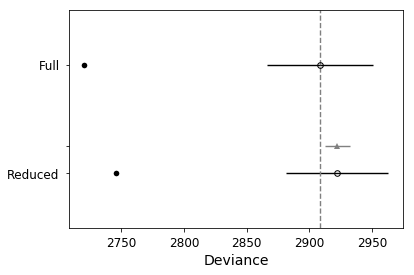

In [14]:
pm.compareplot(df_comp_LOO)

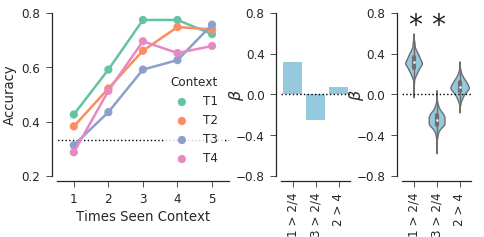

In [15]:
betas = pd.DataFrame({
        'T1vsT2/4': trace['beta_ctxT1vs24'],
        'T3vsT2/4': trace['beta_ctxT3vs24'],
        'T2vsT4':   trace['beta_ctxT2vs4']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(7.43, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1, 1], wspace=0.5)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2]))
    
    # show time series data as well
    df = proc_data[~proc_data['Training'] & proc_data['In Goal']].copy()
    
    ax=axes[0]
    sns.pointplot(x='Times Seen Context', y='Accuracy', hue='Context', #units='uniqueid',
                  estimator=np.mean, marker='.',
                        data=df[df['Times Seen Context'] < 6], palette='Set2', ax=ax, ci=None)

    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')

    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    ax.set_xticklabels(range(1, 11))
    ax.set_ylabel('Accuracy')
    ax.plot([-1, 6], [1./3, 1./3], 'k:')
    ax.set_ylim([0.2, 0.8])
    sns.despine(offset=5)

    ax = axes[1]
    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=axes[1],
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT2/4', 'T3vsT2/4', 'T2vsT4'])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})

    ax = axes[2]
    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
                 estimator=np.median, color='skyblue', 
                   order=['T1vsT2/4', 'T3vsT2/4', 'T2vsT4'])
    ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})
    
    for ii in range(1, 3):
        plt.sca(axes[ii])
        plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
        axes[ii].plot([-1, 3], [0, 0], 'k:')
        axes[ii].set_yticks([-0.8, -.4, 0, 0.4, 0.8])
        axes[ii].set_xlabel('')

    for ii, label in enumerate(['beta_ctxT1vs24', 'beta_ctxT3vs24','beta_ctxT2vs4']):
        if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
            ax.annotate("*", xy=(ii-0.22, 0.6), size=28)
    plt.savefig('exp1_fig_data.png', dpi=300, bbox_inches='tight')

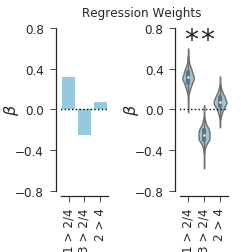

In [16]:
betas = pd.DataFrame({
        'T1vsT2/4': trace['beta_ctxT1vs24'],
        'T3vsT2/4': trace['beta_ctxT3vs24'],
        'T2vsT4':   trace['beta_ctxT2vs4']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(3, 3))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=1.5)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]))    

    ax = axes[0]
    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=ax,
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT2/4', 'T3vsT2/4', 'T2vsT4'])
    ax.set_ylabel(r'$\beta$', labelpad=-6, fontdict={'size': 16, 'weight': 'bold'})

    ax = axes[1]
    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
                 estimator=np.median, color='skyblue', 
                   order=['T1vsT2/4', 'T3vsT2/4', 'T2vsT4'])
    ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
    ax.set_ylabel(r'$\beta$', labelpad=-6, fontdict={'size': 16, 'weight': 'bold'})
    
    sns.despine(offset=5)
    
    for ii in range(0, 2):
        plt.sca(axes[ii])
        plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
        axes[ii].plot([-1, 3], [0, 0], 'k:')
        axes[ii].set_yticks([-0.8, -.4, 0, 0.4, 0.8])
        axes[ii].set_xlabel('')

    for ii, label in enumerate(['beta_ctxT1vs24', 'beta_ctxT3vs24','beta_ctxT2vs4']):
        if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
            ax.annotate("*", xy=(ii-0.22, 0.6), size=28)
            
    plt.suptitle('Regression Weights')
            
    plt.savefig('exp1_fig1b_data.png', dpi=300, bbox_inches='tight')

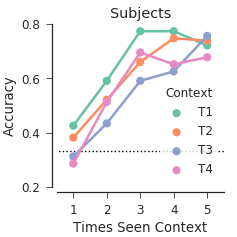

In [17]:
betas = pd.DataFrame({
        'T1vsT2/4': trace['beta_ctxT1vs24'],
        'T3vsT2/4': trace['beta_ctxT3vs24'],
        'T2vsT4':   trace['beta_ctxT2vs4']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(figsize=(3, 3))
    
    # show time series data as well
    df = proc_data[~proc_data['Training'] & proc_data['In Goal']].copy()
    
    sns.pointplot(x='Times Seen Context', y='Accuracy', hue='Context', #units='uniqueid',
                  estimator=np.mean, marker='.',
                        data=df[df['Times Seen Context'] < 6], palette='Set2', ax=ax, ci=None)

    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')

    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    ax.set_xticklabels(range(1, 11))
    ax.set_ylabel('Accuracy')
    ax.plot([-1, 6], [1./3, 1./3], 'k:')
    ax.set_ylim([0.2, 0.8])
    ax.set_title('Subjects')
    sns.despine(offset=5)

#     ax = axes[1]
#     sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=axes[1],
#                  estimator=np.median, color='skyblue', ci=None,
#                    order=['T1vsT2/4', 'T3vsT2/4', 'T2vsT4'])
#     ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})

#     ax = axes[2]
#     sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
#                  estimator=np.median, color='skyblue', 
#                    order=['T1vsT2/4', 'T3vsT2/4', 'T2vsT4'])
#     ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
#     ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})
    
#     for ii in range(1, 3):
#         plt.sca(axes[ii])
#         plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
#         axes[ii].plot([-1, 3], [0, 0], 'k:')
#         axes[ii].set_yticks([-0.8, -.4, 0, 0.4, 0.8])
#         axes[ii].set_xlabel('')

#     for ii, label in enumerate(['beta_ctxT1vs24', 'beta_ctxT3vs24','beta_ctxT2vs4']):
#         if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
#             ax.annotate("*", xy=(ii-0.22, 0.6), size=28)
    plt.savefig('exp1_fig1a_data.png', dpi=300, bbox_inches='tight')

In [18]:
# asses accuracy on first trial in test contexts
# Do a "Bayesian Analysis" to follow up
# Generate the data
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1)  & ~proc_data['Training'] ]

y_t1 = d0.loc[d0.Context == 6, 'Accuracy'].values 
y_t2 = d0.loc[d0.Context == 7, 'Accuracy'].values 
y_t3 = d0.loc[d0.Context == 8, 'Accuracy'].values 
y_t4 = d0.loc[d0.Context == 9, 'Accuracy'].values 


with pm.Model() as binom_model:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    theta4 = pm.Beta('theta4', 10e-5, 10e-5)  # prior
    # define the likelihood
    y_t1 = pm.Bernoulli('y_t1', p=theta1, observed=y_t1)
    y_t2 = pm.Bernoulli('y_t2', p=theta2, observed=y_t2)
    y_t3 = pm.Bernoulli('y_t3', p=theta3, observed=y_t3)
    y_t4 = pm.Bernoulli('y_t4', p=theta4, observed=y_t4)
    
    # Generate a MCMC chain
    trace_bin = pm.sample(10000, pm.Metropolis())  # Use Metropolis sampling
    
print np.mean(trace_bin['theta1'] > 1/3.)
print np.mean(trace_bin['theta2'] > 1/3.)
print np.mean(trace_bin['theta3'] > 1/3.)
print np.mean(trace_bin['theta4'] > 1/3.)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta4_logodds__]
>Metropolis: [theta3_logodds__]
>Metropolis: [theta2_logodds__]
>Metropolis: [theta1_logodds__]
100%|██████████| 10500/10500 [01:06<00:00, 157.31it/s]


0.98
0.86045
0.31365
0.13625


TypeError: 'DataFrame' object is not callable

In [19]:
pm.summary(trace_bin)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.425524,0.045655,0.000341,0.336737,0.514122,13479.0,0.999964
theta2,0.382568,0.045397,0.000393,0.291151,0.468738,12862.0,0.999973
theta3,0.313573,0.042833,0.000380,0.232968,0.399144,12026.0,0.999963
theta4,0.287023,0.042004,0.000374,0.205869,0.368567,13106.0,0.999950


In [20]:
trace.varnames

['beta_ctxT1vs24',
 'beta_ctxT3vs24',
 'beta_ctxT2vs4',
 'beta_times',
 'beta_reps',
 'mu_subj',
 'sigma_sub_log__',
 'a_subj',
 'eps_log__',
 'sigma_sub',
 'eps']

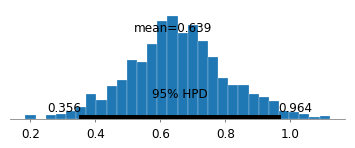

In [21]:
pm.plot_posterior(trace['beta_ctxT1vs24'] - trace['beta_ctxT3vs24'] + trace['beta_ctxT2vs4'])

In [22]:
np.mean((trace['beta_ctxT1vs24'] - trace['beta_ctxT3vs24'] + trace['beta_ctxT2vs4']) > 0)

1.0